# 2: Data engineering

The hand-in exercise for this topic is Task 7 from the notebook “DE_Task.ipynb”. The
exercise asks you to wrap the functionality of other tasks in this notebook into an ETL
pipeline. Note that the GroupBY tasks (which are extra) are not needed in this ETL
pipeline. The data visualization parts are also not needed. The pipeline should contain
some of the data cleaning (such as removing duplicates and nulls) and then creation of
features which are part of task 4 and 5.

### Assemble and imports

Download dataset from kaggle and import needed libs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

In [2]:
path = kagglehub.dataset_download("lakshmi25npathi/online-retail-dataset")

print("Path to dataset files:", path)

100%|██████████| 43.3M/43.3M [00:01<00:00, 23.2MB/s]

Extracting files...


Path to dataset files: C:\Users\abjar\.cache\kagglehub\datasets\lakshmi25npathi\online-retail-dataset\versions\1


In [3]:
dataset_path = path

files = os.listdir(dataset_path)
print(files)


['online_retail_II.xlsx']


In [4]:
file_path = path + "/online_retail_II.xlsx"

df = pd.read_excel(file_path)

---

### Datacleaning

First looks, datacleaning to prepare data for visulization and ideation.

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [7]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


The dataset seems to have some missing values, lets handle those first.

In [8]:
# Sum of missing values
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [9]:
# Fill missing 'Description' using the most common value per 'StockCode'
df['Description'] = df.groupby('StockCode')['Description'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
# There should be 0 missing values now
df.isnull().sum()

Invoice             0
StockCode           0
Description       365
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

even though there are around 20% missing values in costumer ids, we have decided to keep the feature, as well as the rows where it is missing. for a sales platform to be missing documentation would be detrimental for book keeping, and not having the costumer ids, would also mean that we cant see which ones are the biggest spenders. 

In [10]:
# Check
df.duplicated().sum()

6865

In [11]:
df[df.duplicated()].head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.0,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.0,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom


Since the duplicates detected, were not true duplicates, we have decided to keep them, as not doing this would mean that we lose date which could have been used otherwise.

### Renaming Invoice to InvoiceNumber to avoid confusion

In [12]:
df.rename(columns={'Invoice': 'InvoiceNumber'}, inplace=True)

---

### Visualization and Exploration looking at general sales trends

Getting an idea of what is possible to analyze using this data.

**a. Transactions over time, are sales improving or declining?**

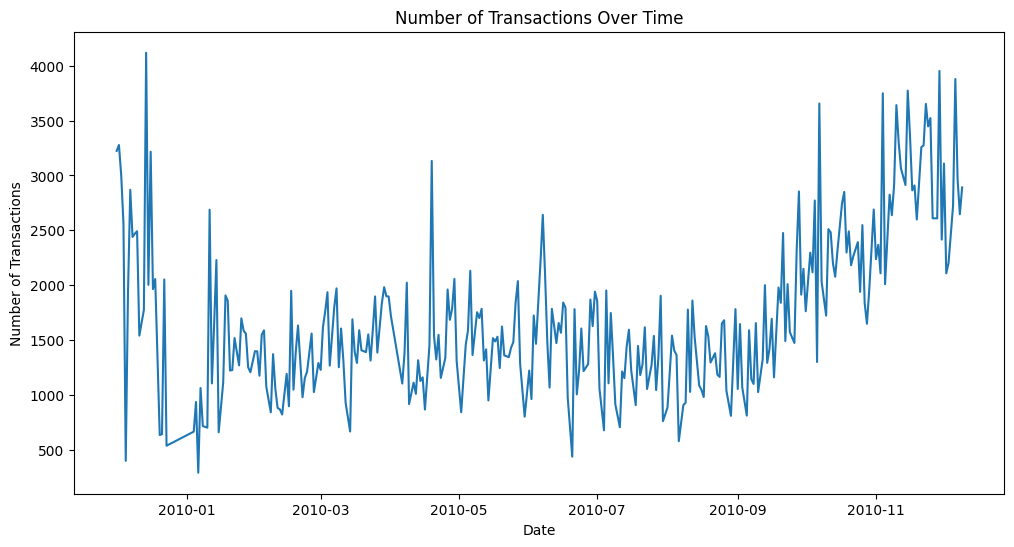

In [13]:
# Formatting date features for plotting
# Convert from string to type:datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Create new 'Date' feature, removing the timestamp
# Making it possilbe to group sales from the same data togther
df['Date'] = df['InvoiceDate'].dt.date
# Group by new 'Date' column and display count of transactions pr date
daily_sales = df.groupby('Date').size()
# Plot
plt.figure(figsize=(12, 6))
daily_sales.plot()
plt.title("Number of Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.show()

**b. Looking at top selling products**

- Which products can be promoted for campaigns.
- Which products are candidates for a association rule mining analysis.

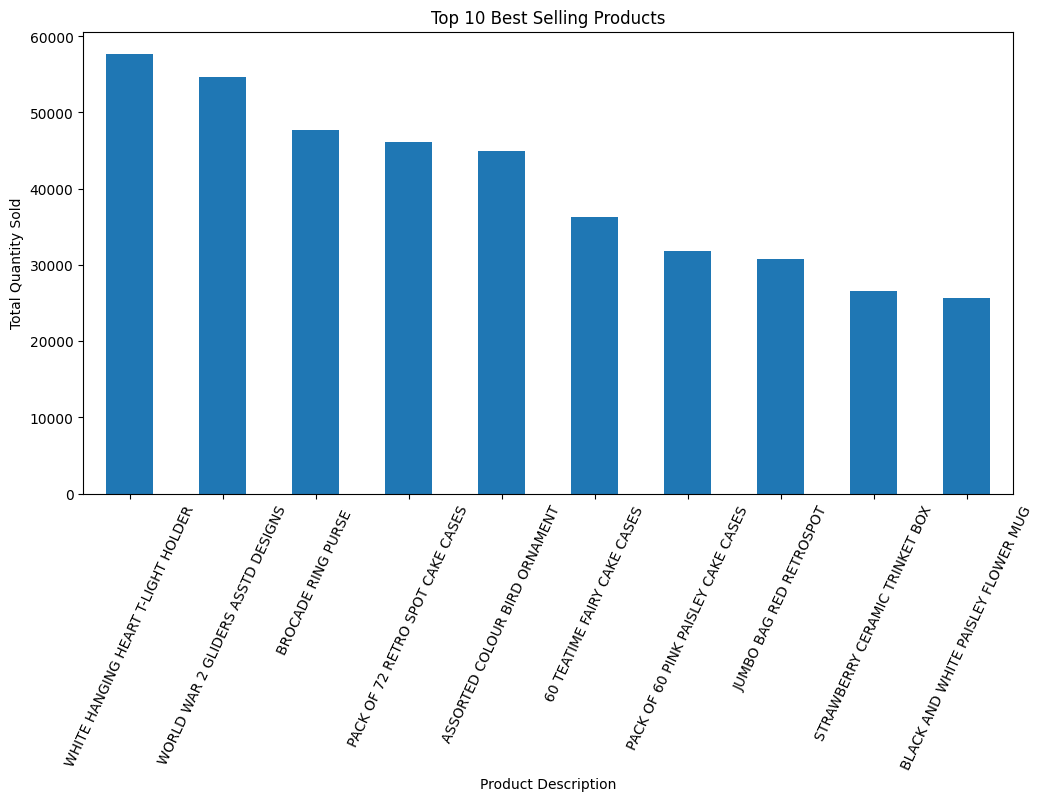

In [14]:
# Group products by their name before plotting
# Count total sum of each product, show 10 highest and sort descending
top_products = df.groupby("Description")["Quantity"].sum().nlargest(10)
# Plot
plt.figure(figsize=(12, 6))
top_products.plot(kind="bar")
plt.title("Top 10 Best Selling Products")
plt.xlabel("Product Description")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=65) # Rotate display names for readability
plt.show()

**c. Countries giving the most business**

- Perhaps it's not worth to focus campaign efforts against countires that aren't good customers.

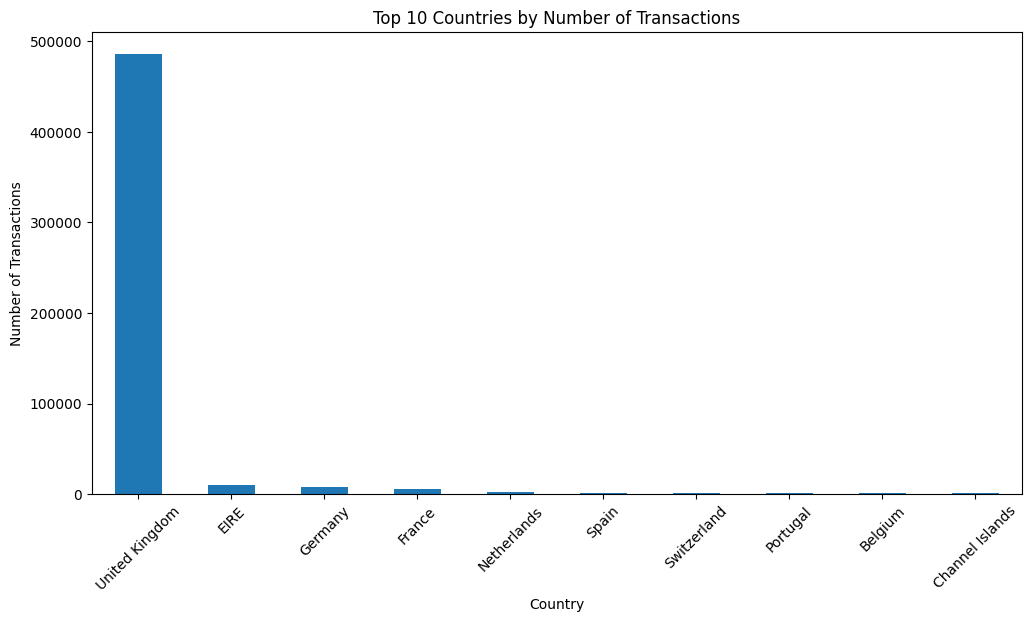

In [15]:
plt.figure(figsize=(12, 6))
# Plot top 10 from output of value_counts
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Country")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45) # Rotate display names again
plt.show()

---

### Feature engineering

Create new features from existing ones, allowing for more precise analysis and use of additional parameters.

Attempting to create the following features:
* **Revenue:** revenue pr item
* **DayOfWeek:** to analyze sales trends by weekdays.
* **TotalRevenue:** for each CustomerID
* **MostPopularProduct:** based on 'Reveune'.
* **Ordersize:** by summing Quantity for each InvoiceNo

In [16]:
# 'Revenue' feature
df['Revenue'] = df['Quantity'] * df['Price']
# Check if it looks correct
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue
5538,489857,82585,SWEET VALENCIA CANDLE+CUP,1,2009-12-02 14:43:00,2.57,NaN,United Kingdom,2009-12-02,2.57
60231,494784,22200,FRYING PAN PINK POLKADOT,1,2010-01-18 13:20:00,8.47,NaN,United Kingdom,2010-01-18,8.47
173940,505866,84997a,GREEN 3 PIECE MINI DOTS CUTLERY SET,1,2010-04-26 13:27:00,7.62,NaN,United Kingdom,2010-04-26,7.62
436057,531036,21002,ROSE DU SUD DRAWSTRING BAG,1,2010-11-05 11:58:00,3.36,NaN,United Kingdom,2010-11-05,3.36
174542,505916,47566,PARTY BUNTING,2,2010-04-26 14:47:00,4.65,15867.0,United Kingdom,2010-04-26,9.30


In [17]:
# 'DayOfWeek' feature egnineering
df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
# Check if it looks correct:
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,DayOfWeek
302553,518851,21724,PANDA AND BUNNIES STICKER SHEET,2,2010-08-12 12:21:00,0.85,15581.0,United Kingdom,2010-08-12,1.70,Thursday
276598,516269,20975,12 PENCILS SMALL TUBE RED SPOTTY,384,2010-07-19 12:19:00,0.65,17404.0,Sweden,2010-07-19,249.60,Monday
153203,503940,79190D,RETRO PLASTIC DAISY TRAY,1,2010-04-08 14:47:00,0.81,NaN,United Kingdom,2010-04-08,0.81,Thursday
502504,536262,22155,STAR DECORATION RUSTIC,6,2010-11-30 15:33:00,0.42,14085.0,United Kingdom,2010-11-30,2.52,Tuesday
469749,C533724,21231,SWEETHEART CERAMIC TRINKET BOX,-1,2010-11-18 13:29:00,1.25,12471.0,Germany,2010-11-18,-1.25,Thursday


In [18]:
# 'TotalRevenue' feature egnineering
df["TotalRevenue"] = df.groupby("Customer ID")["Revenue"].transform("sum")
# Check if it looks correct:
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,DayOfWeek,TotalRevenue
262978,514774,82581,TOILET METAL SIGN,12,2010-07-06 10:22:00,0.55,14911.0,EIRE,2010-07-06,6.60,Tuesday,137675.91
5001,489856,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,1,2009-12-02 14:36:00,5.17,NaN,United Kingdom,2009-12-02,5.17,Wednesday,NaN
416747,C529187,21907,I'M ON HOLIDAY METAL SIGN,-2,2010-10-26 18:44:00,2.10,13552.0,United Kingdom,2010-10-26,-4.20,Tuesday,3079.10
178186,506277,22518,CHILDS GARDEN BRUSH BLUE,6,2010-04-28 15:40:00,2.10,17581.0,United Kingdom,2010-04-28,12.60,Wednesday,7511.36
455156,532626,22057,CERAMIC PLATE STRAWBERRY DESIGN,12,2010-11-12 15:33:00,1.49,12779.0,Poland,2010-11-12,17.88,Friday,2538.06


In [19]:
# 'MostPopularProduct' feature egnineering
most_popular_product = df.groupby("StockCode")["Revenue"].sum().idxmax()
# Check if it looks correct:
most_popular_product

22423

In [20]:
# 'Ordersize' feature egnineering
df["OrderSize"] = df.groupby("InvoiceNumber")["Quantity"].transform("sum")
# Check if it looks correct:
df.sample(5)

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,DayOfWeek,TotalRevenue,OrderSize
230653,511669,22070,SMALL RED RETROSPOT MUG IN BOX,2,2010-06-09 14:41:00,3.75,14099.0,United Kingdom,2010-06-09,7.50,Wednesday,2607.54,205
356697,524014,84991,60 TEATIME FAIRY CAKE CASES,24,2010-09-27 09:55:00,0.55,16592.0,United Kingdom,2010-09-27,13.20,Monday,3551.18,637
368424,525031,21379,CAMPHOR WOOD PORTOBELLO MUSHROOM,1,2010-10-03 12:18:00,1.25,13838.0,United Kingdom,2010-10-03,1.25,Sunday,1274.36,40
515746,537396,84031B,CHARLIE LOLA BLUE HOT WATER BOTTLE,1,2010-12-06 14:08:00,4.65,17223.0,United Kingdom,2010-12-06,4.65,Monday,446.74,64
371032,525221,22421,LIPSTICK PEN FUSCHIA,1,2010-10-04 12:51:00,0.85,NaN,United Kingdom,2010-10-04,0.85,Monday,NaN,567


# ETL Pipeline

To create the extra feature of 'CustomerTier' using lambda, and wrapping all preprocessing steps seen so far in this notebook in a ETL pipeline
* Create a function for loading the data
* Create a function for data cleaning steps
* Create a function for feature engineering
* Create a function applying lambda to create additional features

In [21]:
def load_dataset(file_path):
    return pd.read_excel(file_path)

In [22]:
# Data cleaning
def clean_data(df):
    # Fill missing 'Description' using the most common value per 'StockCode'
    df['Description'] = df.groupby('StockCode')['Description'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
    # Rename 'Invoice' to 'InvoiceNumber'
    df.rename(columns={'Invoice': 'InvoiceNumber'}, inplace=True)
    return df

In [23]:
# Feature engineering
def create_features(df):
    # 'Revenue' feature
    df['Revenue'] = df['Quantity'] * df['Price']
    # 'DayOfWeek' feature
    df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
    # 'TotalRevenue' feature
    df["TotalRevenue"] = df.groupby("Customer ID")["Revenue"].transform("sum")
    # 'MostPopularProduct' feature
    most_popular_product = df.groupby("StockCode")["Revenue"].sum().idxmax()
    df["MostPopularProduct"] = most_popular_product
    # 'OrderSize' feature
    df["OrderSize"] = df.groupby("InvoiceNumber")["Quantity"].transform("sum")
    return df

In [24]:
# Apply lambda functions
def apply_lambda_functions(df):
    # Segment customers into tiers based on TotalRevenue
    df["CustomerTier"] = df["TotalRevenue"].apply(lambda x: "High" if x > 1000 else "Medium" if x > 500 else "Low")
    return df

The result is a reuseable ETL pipeline that apply all these steps to the DF, preparing multiple dataframes in quick succesion

In [25]:
# RSEULT: ETL pipeline
def etl_pipeline(file_path):
    df = load_dataset(file_path)
    df = clean_data(df)
    df = create_features(df)
    df = apply_lambda_functions(df)
    return df

In [26]:
# Freshly declared a new dataframe to test the pipeline, it will preproccess the data the same way as i did manually in the notebook
new_df = etl_pipeline(file_path)
new_df.head()

,InvoiceNumber,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,DayOfWeek,TotalRevenue,MostPopularProduct,OrderSize,CustomerTier
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,Tuesday,1187.08,22423,166,High
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Tuesday,1187.08,22423,166,High
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,Tuesday,1187.08,22423,166,High
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,Tuesday,1187.08,22423,166,High
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,Tuesday,1187.08,22423,166,High


---